<a href="https://colab.research.google.com/github/Sagar-modelling/EAST-CRNN_OCR/blob/main/EAST%2BCRNN_OCR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install tensorflow==1.14

In [4]:
!pip install opencv-python==4.4.0.40

In [5]:
from google.colab.patches import cv2_imshow
import numpy as np
import cv2

In [7]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [8]:
!tar -xzvf "/content/gdrive/MyDrive/frozen_east_text_detection.tar.gz"

frozen_east_text_detection.pb


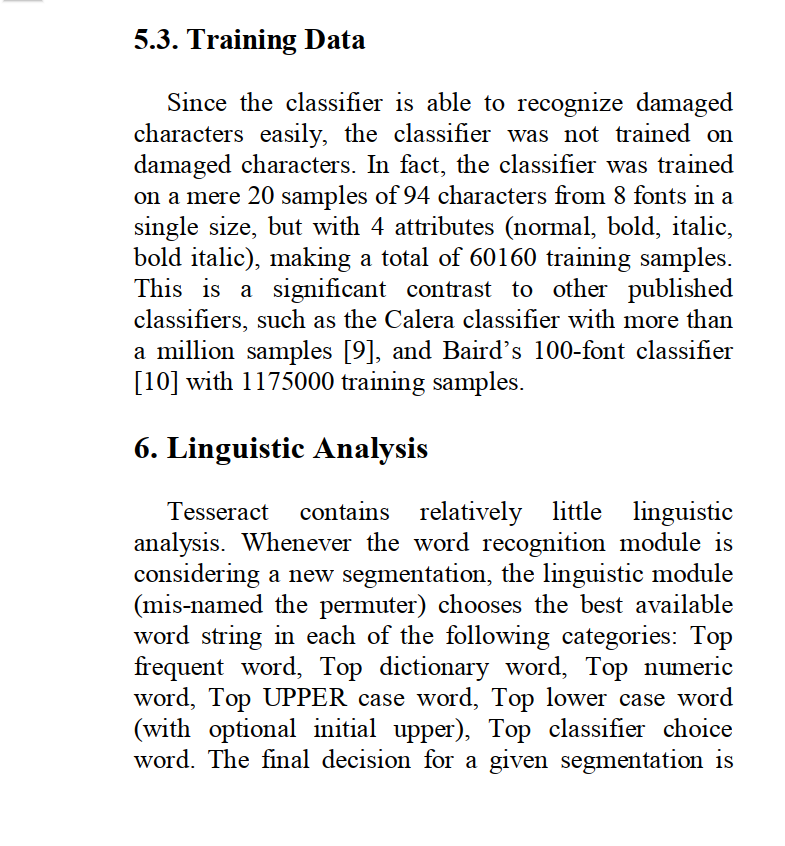

In [ ]:
img = cv2.imread('/content/skew_normal.png')
cv2_imshow(img)

In [ ]:
ret, thresh = cv2.threshold(img, 70, 255, cv2.THRESH_BINARY) #image preprocessing

In [ ]:
# Download the EAST model and Load it
model = cv2.dnn.readNet('/content/frozen_east_text_detection.pb')
model1 = cv2.dnn.readNet('/content/gdrive/MyDrive/crnn.onnx')

In [ ]:
# ## Prepare the image
# use multiple of 32 to set the new img shape
height, width, _ = thresh.shape
new_height = (height//32)*32
new_width = (width//32)*32
print(new_height, new_width)

832 768


In [ ]:
# get the ratio change in width and height
h_ratio = height/new_height
w_ratio = width/new_width
print(h_ratio, w_ratio)

1.0168269230769231 1.0221354166666667


In [ ]:
blob = cv2.dnn.blobFromImage(thresh, 1, (new_width, new_height),(123.68, 116.78, 103.94), True, False)

In [ ]:
model.setInput(blob)

In [ ]:
model.getUnconnectedOutLayersNames() #get names of output layers that calculate geometry maps(concat_3) and scores(Conv_7) respectively.

['feature_fusion/concat_3', 'feature_fusion/Conv_7/Sigmoid']

In [ ]:
(geometry, scores) = model.forward(model.getUnconnectedOutLayersNames()) ## -------------  Forward Propagation  -------------

In [ ]:
(geometry).shape

(1, 5, 208, 192)

In [ ]:
(scores).shape

(1, 1, 208, 192)

In [ ]:
# ## Post-Processing
rectangles = [] #list 1
confidence_score = [] #list 2
for i in range(geometry.shape[2]): #iterate each pixel row by row to construct counding boxes. shape[2] pixel value = 208
    for j in range(0, geometry.shape[3]):  #shape[3] pixel value =192
        
        if scores[0][0][i][j] < 0.1:  #if score of pixel is less than threshold then we don't consider the pixel and we continue
            continue
            #otherwise obtain bounding box coordinates as follows
        bottom_x = int(j*4 + geometry[0][1][i][j])
        bottom_y = int(i*4 + geometry[0][2][i][j])
        

        top_x = int(j*4 - geometry[0][3][i][j])
        top_y = int(i*4 - geometry[0][0][i][j])
        
        rectangles.append((top_x, top_y, bottom_x, bottom_y))
        confidence_score.append(float(scores[0][0][i][j]))

In [ ]:
from imutils.object_detection import non_max_suppression

In [ ]:
# use Non-max suppression to get the required rectangles
import numpy as np
fin_boxes = non_max_suppression(np.array(rectangles), probs=confidence_score, overlapThresh=0.5) #this NMS function only works for non roated text boxes.
fin_boxes

array([[593, 210, 643, 230],
       [282,  90, 380, 109],
       [614, 271, 720, 295],
       [264, 674, 337, 695],
       [547, 736, 687, 759],
       [456, 242, 521, 262],
       [163,  90, 221, 110],
       [169, 426, 296, 454],
       [654, 706, 717, 725],
       [132, 364, 175, 387],
       [385, 213, 490, 232],
       [416, 490, 512, 515],
       [422, 366, 515, 386],
       [655, 212, 713, 231],
       [188,  26, 295,  50],
       [372, 644, 477, 665],
       [394, 275, 486, 294],
       [131, 616, 181, 632],
       [432, 182, 537, 201],
       [483, 150, 582, 170],
       [617, 492, 722, 512],
       [131, 646, 215, 666],
       [336, 554, 483, 573],
       [307, 426, 421, 453],
       [252, 122, 315, 140],
       [491, 214, 577, 232],
       [268, 273, 387, 292],
       [130, 554, 259, 573],
       [382, 709, 461, 731],
       [536, 704, 634, 726],
       [535, 554, 630, 573],
       [265, 242, 351, 263],
       [622,  88, 716, 112],
       [645, 151, 715, 170],
       [434, 3

In [ ]:
alphabet_set = "0123456789abcdefghijklmnopqrstuvwxyz"
blank = '-'

In [ ]:
char_set = blank + alphabet_set

### --------------- Load the CRNN decoding functions -------------

In [ ]:
# Decode the scores to text
def most_likely(scores, char_set):
    text = ""
    for i in range(scores.shape[0]):
        c = np.argmax(scores[i][0])
        text += char_set[c]
    return text

In [ ]:
def map_rule(text): #apply mapping rule
    char_list = []
    for i in range(len(text)):
        if i == 0:
            if text[i] != '-':
                char_list.append(text[i])
        else:
            if text[i] != '-' and (not (text[i] == text[i - 1])):
                char_list.append(text[i])
    return ''.join(char_list)

In [ ]:
def best_path(scores, char_set):
    text = most_likely(scores, char_set)
    final_text = map_rule(text)
    return final_text

In [ ]:
## ---------------  Recognize the text using CRNN in each segment -----------
#display text boxes and converting to original shape
img_copy = thresh.copy()
for (x1, y1, x2, y2) in fin_boxes:

    x1 = int(x1 * w_ratio)
    y1 = int(y1 * h_ratio)
    x2 = int(x2 * w_ratio)
    y2 = int(y2 * h_ratio)

    segment = img[y1:y2, x1:x2, :] #crop segments for inputting them to CRNN Model

    segment_gray = cv2.cvtColor(segment, cv2.COLOR_BGR2GRAY)
    blob = cv2.dnn.blobFromImage(segment_gray, scalefactor=1/127.5, size=(100,32), mean=127.5)
    model1.setInput(blob)
    scores = model1.forward()
    text = best_path(scores, char_set)
    print(text)
    cv2.rectangle(img_copy, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(img_copy, text.strip(), (x1,y1-2), cv2.FONT_HERSHEY_COMPLEX, 0.7, (0,0,255),2)

bold
classifier
published
jpper
segmentation
60160
since
linguistic
choice
tl0
attributes
selatively
samples
italic
fraining
dictionary
contrast
worc
characters
classife
linguistic
frequen
segmentation
analysis
easily
inormal
significant
considering
uppery
classifier
inguistic
making
damaged
trained
bairds
contains
decision
tranec
classifier
such
numeric
module
module
little
samples
million
recognize
data
classifier
following
word
font
100
classifier
tesseract
vhenever
able
training
talicy
1i75000
optional
permutery
word
ategories
characters
samples
this
with
fonts
classifiers
lower
characters
more
but
word
analysis
was
other
case
best
samples
fom
the
final
given
initial
the
recognition
mere
tranino
20
bold
xwith
damaged
194
top
available
each
erax
total
case
than
not
the
fact
word
was
the
they
single
new
the
word
string
size
the
top
he
chooses
and
top
top
top
1l9
thel
for
words
word
with
misname
in
as
on
the
with
on
to
ot
53
top
104
jof
of
1n
1s
to
js


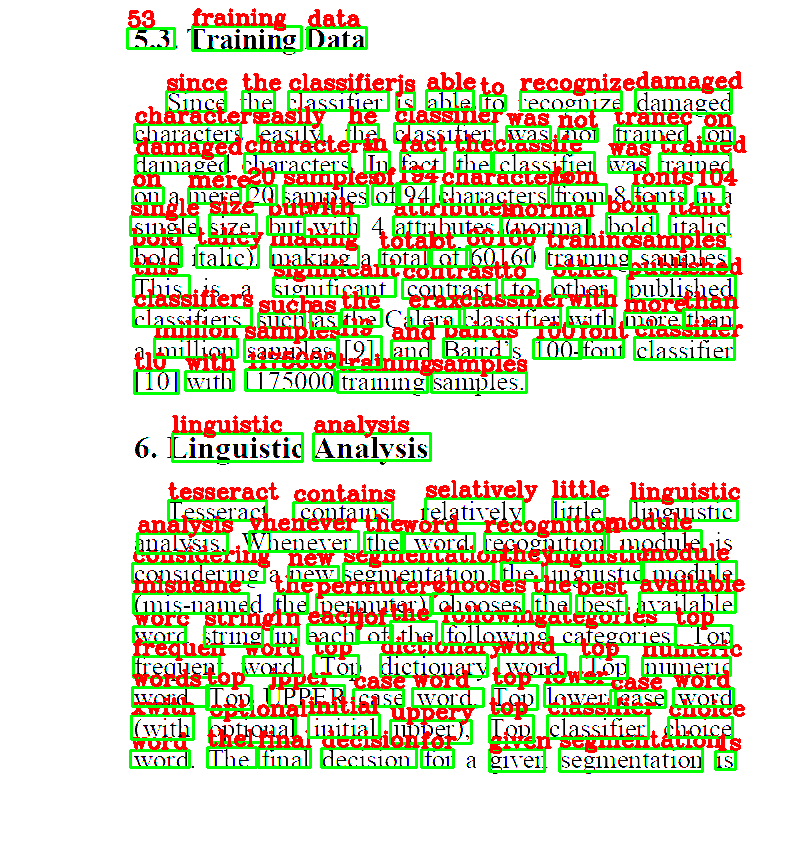

In [ ]:
cv2_imshow(img_copy)